# Machine learning
### Ivaylo Ivanov and Aleksandar Georgiev

### Overview

The goal of this task is to use machine learning to build a recipe recommendation system based on the data from the previously explored datasets.

The main tools used in this notebook are the scikit learn machine learning library, pandas and numpy. We additionally use the kneed library to find the ideal cluster size, as well as matplotlib to visualize the clusters.

To begin, we import the libraries we are going to use and read the datasets:

In [87]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from kneed import KneeLocator

In [88]:
pd.set_option('display.max_columns', None)

recipe_cooktime = pd.read_csv('./exp/recipe_cooktime.csv')
recipe_ingredient = pd.read_csv('./exp/recipe_ingredient.csv')
recipe_nutrition = pd.read_csv('./exp/recipe_nutrition.csv')
recipe_names = pd.read_csv('./data/recipe.csv')

We then need to build a clustering dataset that we will use with the machine learning library. All field included in this frame will be features. We experimented with a variety of different combinations to see how the algorithm groups them and concluded it is most reasonable to only include protein, carbohydrate and fat quantity in the foods to base our recommendation off of. 

We also tried including other nutritional elements, such as cholesterol, or other charasteristics of the recipes, such as number of ingredients contained or preparation/cooking time. However, the clusters that emerged from these configurations did not turn out well, since they were way too close together.

In [89]:
clustering_dataset = pd.DataFrame(columns = ['recipe_id', 'protein', 'carbo', 'total_fat'], data = recipe_nutrition[['recipe_id', 'protein', 'carbo', 'total_fat']].values)
clustering_dataset['recipe_id'] = clustering_dataset['recipe_id'].astype(int)
# clustering_dataset['prep_min'] = recipe_cooktime['prep_min']
clustering_dataset.set_index("recipe_id", inplace=True)
clustering_dataset

,protein,carbo,total_fat
recipe_id,,,
214,5.47,41.29,11.53
215,5.70,23.75,1.08
216,4.90,26.88,1.10
217,1.77,18.17,0.21
218,1.38,36.63,5.47
...,...,...,...
1410,6.50,28.81,45.24
1411,3.24,38.67,35.89
1426,6.29,29.24,6.50


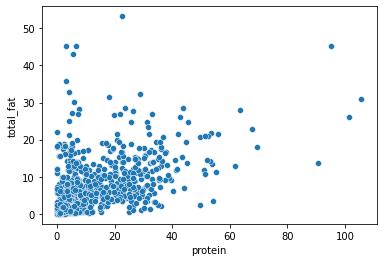

In [90]:
sns.scatterplot(data=clustering_dataset, x="protein", y="total_fat");

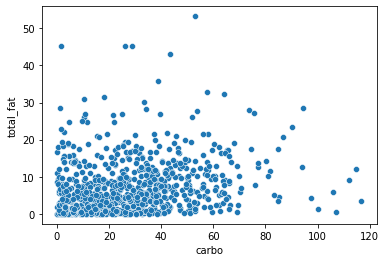

In [91]:
sns.scatterplot(data=clustering_dataset, x="carbo", y="total_fat");

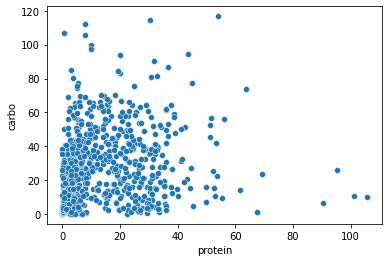

In [92]:
sns.scatterplot(data=clustering_dataset, x="protein", y="carbo");

In [93]:
scaler = StandardScaler()
clustering_dataset = scaler.fit_transform(clustering_dataset)

We then use the KneeLocator method from the kneed library to find the ideal k. We do that by passing it the sse (sum of squared errors) for different values for k.

In [94]:
sse = []

for i in range(1, 11):
    clf = KMeans(n_clusters=i)
    labels = clf.fit_predict(clustering_dataset)
    sse.append(clf.inertia_)

# plt.style.use("fivethirtyeight")
# plt.plot(range(1, 11), sse)
# plt.xticks(range(1, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

kl = KneeLocator(range(1, 11), sse, curve="convex", direction="decreasing")
kl.elbow

3

Afterwards, the clusters are visualized:

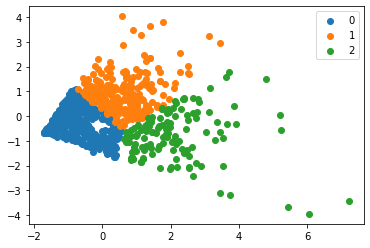

In [95]:
df = PCA(2).fit_transform(clustering_dataset)
k_means = KMeans(n_clusters=kl.elbow)
label = k_means.fit_predict(df)

#Getting unique labels
 
u_labels = np.unique(label)
 
#plotting the results:

for i in u_labels:
    plt.scatter(df[label == i , 0] , df[label == i , 1] , label = i)
plt.legend()
plt.show()

We can see that the clusters are not perfect, as they are not far apart and approximately round, however this is the best grouping that sklearn could come up with with the given features.

Now that we have our four clusters, we proceed to build the recommendation system:

Running the cell below will yield a list of 4 recipes. The user is meant to choose one of the recipes.

In [96]:
import random
import sys

actual_choice = -1
choice_made = False
recommended_recipes_indices = []

while True:
    recommended_recipes = []

    if not choice_made:
        while len(recommended_recipes) < kl.elbow:
            index = random.choice(range(1, len(clustering_dataset)))
            if len(recommended_recipes) == label[index]:
                recommended_recipes.append(recipe_names.iloc[index]['title'])
                recommended_recipes_indices.append(index)

        print(recommended_recipes)

    else:
        while len(recommended_recipes) < kl.elbow:
            index = random.choice(range(1, len(clustering_dataset)))
            if label[index] == actual_choice:
                recommended_recipes.append(recipe_names.iloc[index]['title'])

        print(recommended_recipes)

    choices = open("./choices/choices.txt", 'r')

    # PUT YOUR CHOICE HERE
    choice = int(input("Which of the following is your preference? "))

    if not choice_made:
        actual_choice = choice
        choice_made = True

    if str(recommended_recipes_indices[choice]) not in choices.read():
        choices.close()
        choices = open("./choices/choices.txt", 'a')
        choices.write(str(recommended_recipes_indices[choice]) + '\n')
        choices.close()

['Bean Soup Romana', 'Pear Zinfandel Ice', 'Beef Fajitas with Fresh Tomatoes']
['Risotto Con Frutti Di Mare', 'Apple Stuffed Squash', 'California Quesadilla']
['Lamb Tortellini Minestrone', 'Boonville Baked Beans', 'Ginger Turkey Stir-Fry']
['Warm Broccoli-Potato Salad', '-Baked Potatoes-', 'Tofu Baked Ziti']
['Cayuga Cookies', '-Baked Potatoes-', 'Grilled Lamb with Spanish Sherry Sauce']
['-Waffles-', '-French Toast-', 'Gruyere Sauced Potatoes']
['Healthclub Chicken Salad', 'Double Corn Brunch Bake', 'Old-Fashioned Peach Cobbler']
['Springtime Pasta', 'Mexican Fiesta Quiche', '-French Toast-']
['Fish Chowder', 'Possible Pumpkin Pie', 'Green and Gold Fettuccine']
['Light Apple Cake', 'Turkey Citrus Salad', 'Western Beans and Rice']
['Quick Crawfish Jambalaya', 'Risotto Con Frutti Di Mare', 'Light Apple Cake']


ValueError: invalid literal for int() with base 10: ''

After choosing a recipe, the user is meant to change the 'choice' variable to the index of the chosen recipe and run the cell below. Running the cell above will then always yield recipes from the same cluster as the initially chosen recipe.